# Identifying Credit Card Fraud: 2. Exploratory Data Analysis
Mark Cohen

2023-4-10

This notebook explores the data. This includes investigating the following:
1. Summary statistics for all features
1. Pairwise correlations of continuous features
1. Distribution of continuous featurs for fraudulent and non-fraudulent transactions
1. Differences in fraud rate across categorical users and other categories

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("../src")
import utils

rng = np.random.default_rng(10)

# Summary statistics for individual features

In [9]:
data_file_loc = utils.prepend_dir('tx_sample.csv')
tx_data = pd.read_csv(
    data_file_loc,
    index_col=0,
    parse_dates=['timestamp']
)
tx_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5214807 entries, 28882 to 24270533
Data columns (total 17 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user            int64         
 1   card            int64         
 2   year            int64         
 3   month           int64         
 4   day             int64         
 5   time            object        
 6   amount          float64       
 7   use_chip        object        
 8   merchant_name   int64         
 9   merchant_city   object        
 10  merchant_state  object        
 11  zip             float64       
 12  mcc             int64         
 13  errors          object        
 14  is_fraud        bool          
 15  timestamp       datetime64[ns]
 16  tx_type         object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(7), object(6)
memory usage: 681.3+ MB


In [4]:
id_vars = ['user', 'card']
cat_vars = ['merchant_city', 'merchant_state', 'mcc', 'tx_type', 'is_fraud']
cont_vars = ['amount', 'timestamp']

In [5]:
# looking at distributions of categorical variables
print("Number of unique values:")
for col in cat_vars:
    print(col, tx_data[col].unique().shape[0])

Number of unique values:
merchant_city 10014
merchant_state 168
mcc 109
tx_type 3
is_fraud 2


In [6]:
print('Counts:')
for col in ['tx_type', 'is_fraud']:
    print(tx_data[col].value_counts())

Counts:
tx_type
swipe     3290783
chip      1318766
online     605258
Name: count, dtype: int64
is_fraud
False    5208758
True        6049
Name: count, dtype: int64


In [7]:
print('Highest values')
for col in ['merchant_city', 'merchant_state', 'mcc']:
    print(
        tx_data[col].value_counts().sort_values(ascending=False).head(),
        'average = ', tx_data[col].count()/len(tx_data[col].unique()),
        tx_data[col].value_counts().sort_values(ascending=False).tail()
    )

Highest values
merchant_city
ONLINE          606862
Philadelphia     67436
Los Angeles      60389
Nashport         48794
Indianapolis     48651
Name: count, dtype: int64 average =  520.7516476932295 merchant_city
Lanett       1
Redby        1
Ridgedale    1
Unalaska     1
Barnum       1
Name: count, dtype: int64
merchant_state
CA    517247
OH    305671
FL    295092
TX    289248
NY    240932
Name: count, dtype: int64 average =  27428.244047619046 merchant_state
Guinea        2
Malta         2
Uzbekistan    2
Venezuela     2
Samoa         1
Name: count, dtype: int64
mcc
5499    609191
5411    602045
5541    587540
5812    390851
5912    306567
Name: count, dtype: int64 average =  47842.266055045875 mcc
4411    137
3008    135
3075    120
3007    113
5733     93
Name: count, dtype: int64


We see here different distributions for the various categorical variables. In this data, swipe transactions remain much more common than chip or online transactions. On the other hand, 'online' is the single most common transaction 'location.'

Also, fraud is relatively rare: less than 1% of the recorded transactions.

Finally, the transactions are clustered in terms of location: the most common cities, states, and store types are much more common on average.

We can distinguish between U.S. and foreign locations by the presence of `zip` code, excluding online transactions.

In [17]:
print(tx_data[(tx_data.tx_type != 'online') & ~tx_data.zip.isna()].merchant_state.sort_values().unique())
print(tx_data[(tx_data.tx_type != 'online') & tx_data.zip.isna()].merchant_state.sort_values().unique())

['AA' 'AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA'
 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT'
 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VA' 'VT' 'WA' 'WI' 'WV' 'WY']
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Aruba' 'Australia'
 'Austria' 'Bahrain' 'Barbados' 'Belgium' 'Bosnia and Herzegovina'
 'Brazil' 'Burkina Faso' 'Cabo Verde' 'Canada' 'Chile' 'China' 'Colombia'
 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark'
 'Dominican Republic' 'East Timor (Timor-Leste)' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Haiti'
 'Honduras' 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Ireland'
 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kuwait' 'Kyrgyzstan'
 'Latvia' 'Liberia' 'Lithuania' 'Luxembourg' 'Macedonia' 'Malaysia'
 'Maldives' 'Mali' 'Malta' 'Mexico' 'Microne

There are a small number of transactions listed as using a chip as `tx_type` but "ONLINE" as merchant city. None of them are fraud. Perhaps they can just be ignored?

In [27]:
print(tx_data[tx_data.tx_type == 'online'].merchant_state.unique())
print(tx_data[tx_data.merchant_state == 'ONLINE'].tx_type.value_counts())
print(tx_data[tx_data.merchant_state.isna()].tx_type.value_counts())
print(tx_data[tx_data.merchant_state.isna() & (tx_data.tx_type == 'chip')].head(3).T)
print(tx_data[tx_data.merchant_state.isna() & (tx_data.tx_type == 'chip')].merchant_city.unique())
print(tx_data[tx_data.merchant_state.isna() & (tx_data.tx_type == 'chip')].is_fraud.sum())

[nan]
Series([], Name: count, dtype: int64)
tx_type
online    605258
chip        1604
Name: count, dtype: int64
                             61603                62499                326014
user                              2                    2                   25
card                              3                    3                    1
year                           2017                 2018                 2017
month                             8                   12                    8
day                              20                   14                   14
time                          23:54                08:14                22:42
amount                       -414.0               260.79               -498.0
use_chip           Chip Transaction     Chip Transaction     Chip Transaction
merchant_name    333722291367506728  7501849281341469857  3694722044710185708
merchant_city                ONLINE               ONLINE               ONLINE
merchant_state                

Moving on to the value of transactions in the `amount` column.

In [8]:
tx_data.amount.describe()

count    5.214807e+06
mean     4.356835e+01
std      8.117185e+01
min     -5.000000e+02
25%      9.030000e+00
50%      3.121000e+01
75%      6.510000e+01
max      6.613440e+03
Name: amount, dtype: float64

We see that the vast majority of transactions are between 0 and 100, there are a small number of negative values (refunds) and larger transactions.

Let's first look at the smaller transactions that make up the bulk of the data.

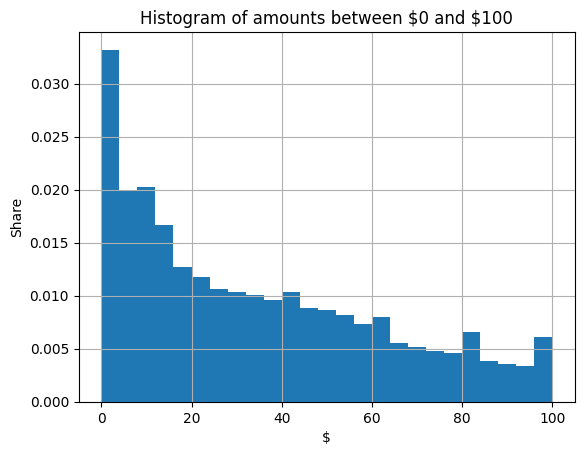

In [9]:
tx_data.loc[tx_data.amount.between(0,100), 'amount'].hist(bins=25, density=True);
plt.title(r'Histogram of amounts between \$0 and \$100');
plt.ylabel('Share');
plt.xlabel('$');

Two things stand out here: 
1. Smaller transactions are more common, even at very small values. As seen below, the most common transaction value is between \$1 and \$2.
1. There are spikes at larger round numbers: 60, 80, 100.

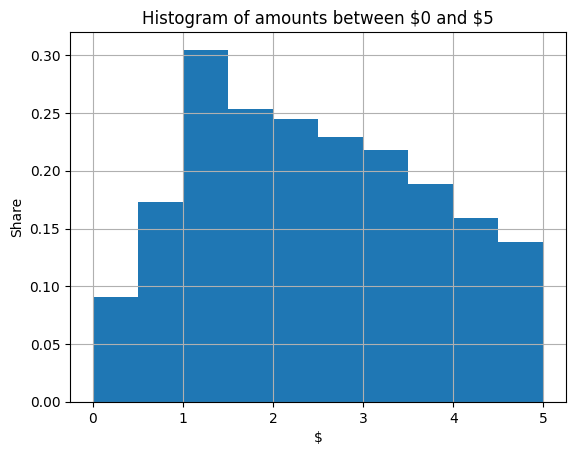

In [10]:
tx_data.loc[tx_data.amount.between(0,5), 'amount'].hist(bins=10, density=True);
plt.title(r'Histogram of amounts between \$0 and \$5');
plt.ylabel('Share');
plt.xlabel('$');

Refunds, somewhat surprisingly, do not just show the same pattern in reverse. Refunds at smaller values (below \$50) are almost non-existent, and refunded values seem almost uniformly distributed between \$50 and \$100.

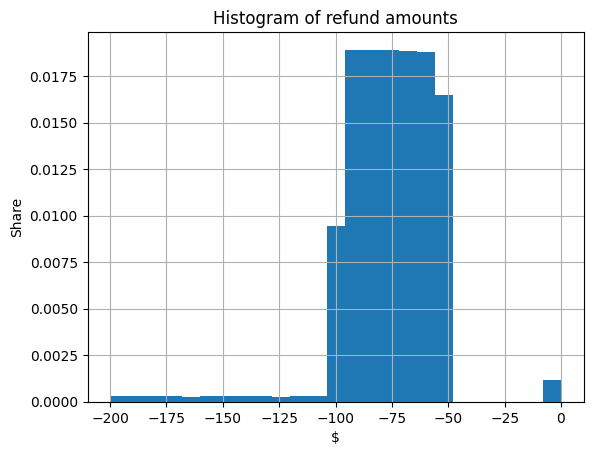

In [11]:
tx_data.loc[tx_data.amount.between(-200, 0), 'amount'].hist(bins=25, density=True);
plt.title(r'Histogram of refund amounts');
plt.ylabel('Share');
plt.xlabel('$');

Finally, to get a glance at the tail of the distribution we can look at some of the higher percentile cutoffs. Larger transactions are very rare.

In [12]:
pct = [90, 95, 99, 99.9, 99.99]
for ptile, value in zip(pct, np.percentile(tx_data.amount, pct)):
    print(f'{ptile:5}%:  ${value:8.02f}')

   90%:  $  107.36
   95%:  $  147.92
   99%:  $  303.12
 99.9%:  $  869.65
99.99%:  $ 1563.36


As for the timing of the transaction, we can see that although the data extends over several decades, it is much denser in the recent past.

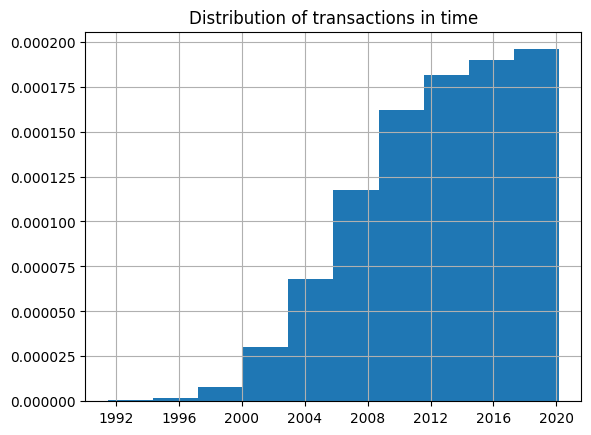

In [13]:
tx_data.timestamp.hist(density=True);
plt.title('Distribution of transactions in time');

We can also look at variations across time within years, months, and days. The distributions here are all intuitive: there is no pattern in months or days, and transactions are much more common during the daytime.

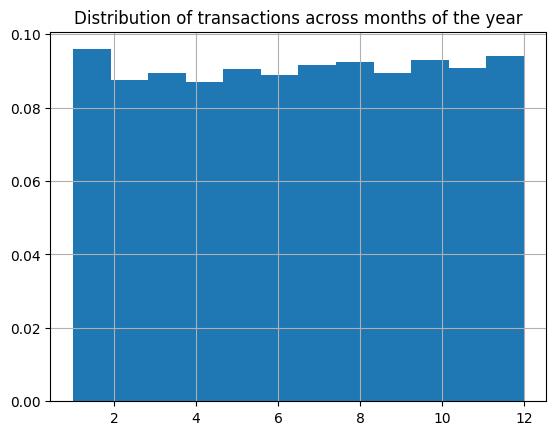

In [14]:
tx_data.month.hist(density=True, bins=12);
plt.title('Distribution of transactions across months of the year');

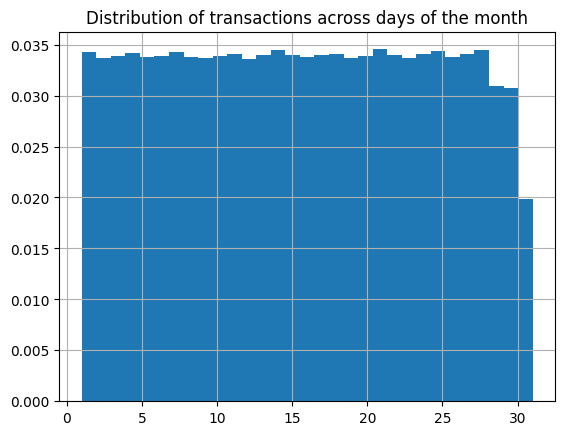

In [15]:
tx_data.day.hist(density=True, bins=31);
plt.title('Distribution of transactions across days of the month');

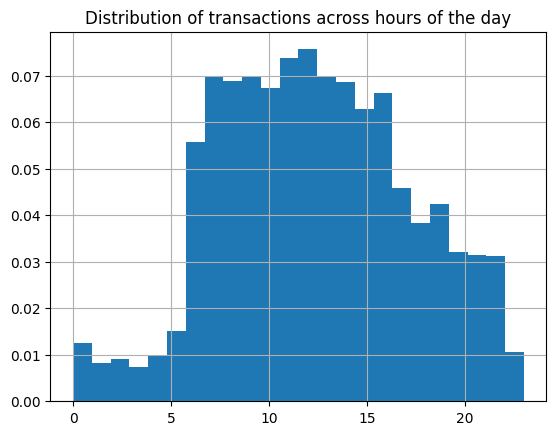

In [16]:
tx_data.timestamp.dt.hour.hist(bins=24, density=True);
plt.title('Distribution of transactions across hours of the day');

# Bivariate patterns

Because almost all of the features are discrete, rather than correlations and scatterplots, we need to compare means across bins.

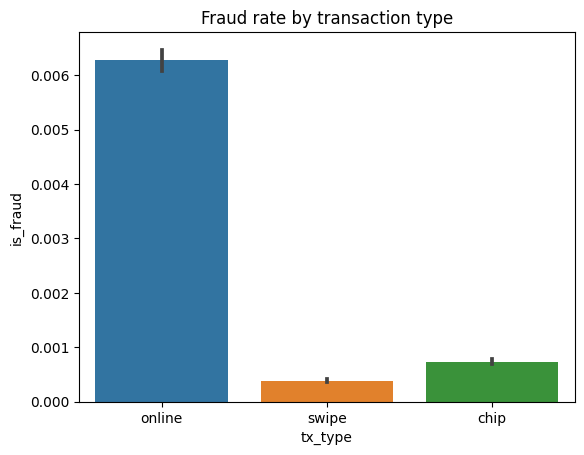

In [17]:
sns.barplot(tx_data, y='is_fraud', x='tx_type');
plt.title('Fraud rate by transaction type');

These rates are quite different, with fraud much more common in online transactions and somewhat more common in chip transactions. Given the large sample size, the error estimates are quite narrow, so these are likely not random variations around a common probability distribution.

In [18]:
def bootstrap_bool(p, n, data, func, n_reps=1000):
    outputs = np.empty(n_reps)
    for i in range(n_reps):
        outputs[i] = func(rng.choice([True, False], n, replace=True, p=[p, 1-p]), data)
    return outputs

In [19]:
online_rate_samples = bootstrap_bool(
    tx_data.is_fraud.mean(), 
    tx_data.is_fraud.count(), 
    tx_data.tx_type, 
    lambda is_fraud, tx_type: is_fraud[tx_type == 'online'].mean(),
    200
)
print(f'{(online_rate_samples >= tx_data.loc[tx_data.tx_type=="online", "is_fraud"].mean()).mean()}')

0.0


In [20]:
# n_reps = 100
# fraud_vals = tx_data.is_fraud
# tx_type_vals = tx_data.tx_type
# online_rate_samples = np.empty(n_reps)
# for i in range(n_reps):
#     online_rate_samples[i] = fraud_vals[rng.permutation(tx_type_vals)=='online'].mean()
# print(f'{(online_rate_samples >= tx_data.loc[tx_data.tx_type=="online", "is_fraud"].mean()).mean()}')

Next, we can compare the distribution of transaction sizes between fraudulent and non-fraudulent transactions. For readability, I look only at transactions (both purchases and refunds) less than \$200.

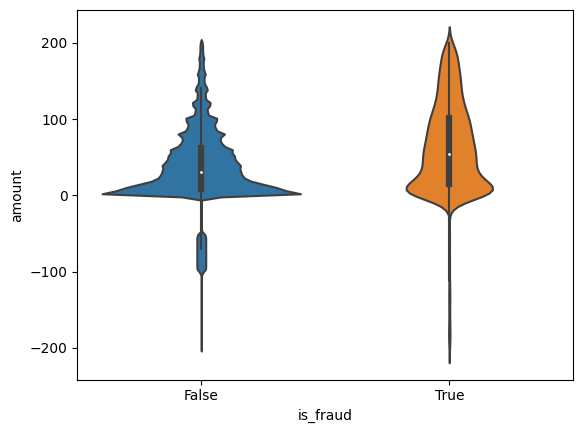

In [21]:
sns.violinplot(tx_data[tx_data.amount.between(-200, 200)], x='is_fraud', y='amount');

1. Unsurprisingly, there are many fewer fraudulent refunds. The fact that there are some is curious, though.
1. Fraudulent transactions have a broadly similar distribution shape, but the details a different: it seems that relatively large purchases are more likely to be fraudulent. Both the mean and median are higher.

In [22]:
tx_data[tx_data.is_fraud].amount.describe()

count    6049.000000
mean      110.788134
std       218.052340
min      -495.000000
25%        18.350000
50%        69.650000
75%       148.650000
max      5694.440000
Name: amount, dtype: float64

We can bootstrap a sampling distribution for the difference in means, to confirm that it is statistically significant.

In [23]:
mean_diff = tx_data[tx_data.is_fraud].amount.mean() - tx_data[~tx_data.is_fraud].amount.mean()
mean_diff_bootstrap = bootstrap_bool(
    tx_data.is_fraud.mean(), 
    tx_data.is_fraud.count(), 
    tx_data.amount, 
    lambda is_fraud, amount: np.abs(amount[is_fraud].mean() - amount[~is_fraud].mean())
)
print(f'Probability that difference is at least as least as great as that observed: {(mean_diff_bootstrap>mean_diff).mean()}')

Probability that difference is at least as least as great as that observed: 0.0


Looking next at timing, the rate of fraud varies year-to-year, though without a clear pattern (other than that there are no labeled fraud cases in the first few years of the dataset).

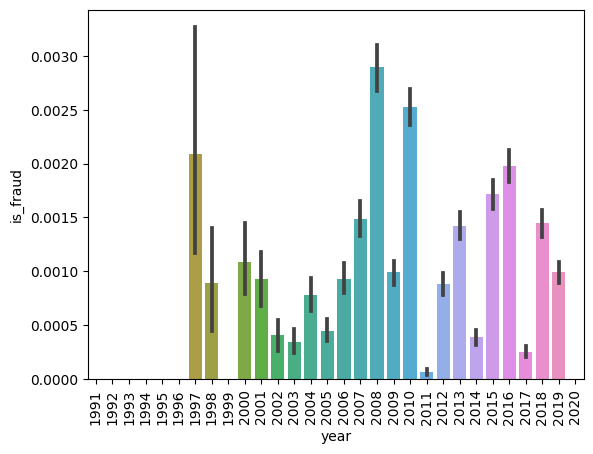

In [24]:
ax = sns.barplot(tx_data, x='year', y='is_fraud');
ax.tick_params(axis='x', labelrotation=90);

Text(0, 0.5, 'Density')

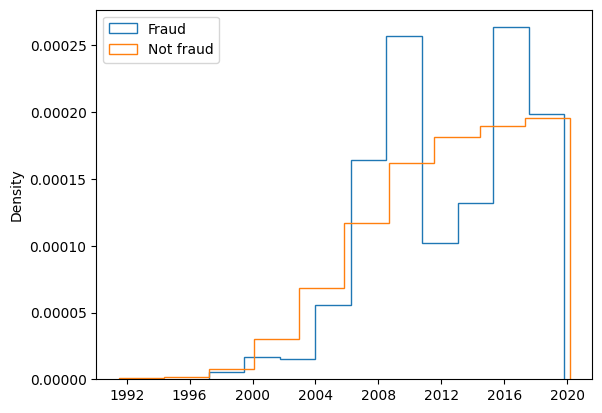

In [25]:
plt.hist(tx_data[tx_data.is_fraud].timestamp, density=True, histtype='step', label='Fraud');
plt.hist(tx_data[~tx_data.is_fraud].timestamp, density=True, histtype='step', label='Not fraud');
plt.legend();
plt.ylabel('Density')

As for time, there are variations again, though the off-peak variations (in the early morning and in the evening) have wide error bars since there are fewer transactions in those periods.

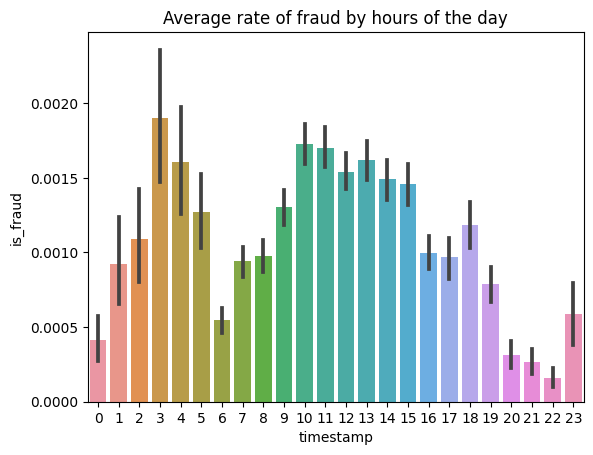

In [26]:
sns.barplot(x=tx_data.timestamp.dt.hour, y=tx_data.is_fraud);
plt.title('Average rate of fraud by hours of the day');

Finally, we can look at patterns of fraud by location and merchant type. Here, instead of trying to plot the large number of values, we can aggregate fraud rates by category and look at the distributions.

First, looking at location (by zip code, thus excluding online transactions, which we already know have higher fraud rates), there is a wide variation. Some of this is clearly random chance, such as the zip codes with only 1 transaction and 1 case of fraud. However, it does seem as if there is a higher fraud rate in low-transaction zip codes. And there are zipcodes with quite high rates of fraud despite having a substantial absolute number of transactions and even fraudulent transactions.

These patterns could be important inputs to modeling later. This can be combined also with information about customer's locations (see below).

In [27]:
zip_rate = tx_data.groupby('zip')['is_fraud'].agg(['count', 'mean']).sort_values('mean', ascending=False)
print(zip_rate.describe())
print(f"\nOf the {zip_rate[zip_rate['count']<5]['count'].sum()} transactions in low-transaction (<5) zip codes, {zip_rate[zip_rate['count']<5].prod(axis=1).sum()/zip_rate[zip_rate['count']<5]['count'].sum()*100:.2f}% are fraudulent.")
print("\nAmong zip codes with at least 50 transactions:")
print(zip_rate[zip_rate['count']>50].head(5))
print("\nAmong zip codes with at least 5 cases of fraud:")
print(zip_rate[zip_rate.prod(axis=1)>5].head(5))

              count          mean
count  19860.000000  19860.000000
mean     230.304431      0.006572
std     1386.016379      0.069982
min        1.000000      0.000000
25%        4.000000      0.000000
50%       12.000000      0.000000
75%       39.000000      0.000000
max    48794.000000      1.000000

Of the 12651 transactions in low-transaction (<5) zip codes, 1.17% are fraudulent.

Among zip codes with at least 50 transactions:
         count      mean
zip                     
44680.0    253  0.229249
46112.0     58  0.068966
21076.0     52  0.057692
94702.0    150  0.053333
85323.0     58  0.051724

Among zip codes with at least 5 cases of fraud:
         count      mean
zip                     
94662.0      6  1.000000
78632.0      6  1.000000
44811.0     26  0.538462
44807.0     18  0.500000
44820.0     27  0.481481


Merchant codes show a similar uneven pattern: there are MCCs with substantially higher rates.

In [28]:
mcc_rate = tx_data.groupby('mcc').is_fraud.agg(['count', 'mean']).sort_values(['mean', 'count'], ascending=False)
print(mcc_rate.describe())
print(f"\nOf the {mcc_rate[mcc_rate['count']<500]['count'].sum()} transactions in low-transaction (<500) MCCs, {mcc_rate[mcc_rate['count']<500].prod(axis=1).sum()/mcc_rate[mcc_rate['count']<500]['count'].sum()*100:.2f}% are fraudulent.")
print("\nAmong MCCs with at least 500 transactions:")
print(mcc_rate[mcc_rate['count']>500].head(5))
print("\nAmong MCCs with at least 50 cases of fraud:")
print(mcc_rate[mcc_rate.prod(axis=1)>50].head(5))

               count        mean
count     109.000000  109.000000
mean    47842.266055    0.019424
std    116477.861057    0.060068
min        93.000000    0.000000
25%      1190.000000    0.000535
50%      5246.000000    0.004906
75%     24127.000000    0.011071
max    609191.000000    0.518248

Of the 2898 transactions in low-transaction (<500) MCCs, 6.73% are fraudulent.

Among MCCs with at least 500 transactions:
      count      mean
mcc                  
5045    896  0.092634
5816    957  0.065831
5732   2676  0.065770
5712   1554  0.062420
5094   2296  0.044425

Among MCCs with at least 50 cases of fraud:
      count      mean
mcc                  
4411    137  0.518248
5045    896  0.092634
5816    957  0.065831
5732   2676  0.065770
5712   1554  0.062420


# Variations by card characteristics

In [4]:
card_data = pd.read_csv(utils.prepend_dir('cards_sample.csv'), index_col=0, parse_dates=['expires', 'acct_open_date'])
card_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1241 entries, 10 to 6109
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user                   1241 non-null   int64         
 1   card_index             1241 non-null   int64         
 2   card_brand             1241 non-null   object        
 3   card_type              1241 non-null   object        
 4   card_number            1241 non-null   int64         
 5   expires                1241 non-null   datetime64[ns]
 6   cvv                    1241 non-null   int64         
 7   has_chip               1241 non-null   bool          
 8   cards_issued           1241 non-null   int64         
 9   credit_limit           1241 non-null   float64       
 10  acct_open_date         1241 non-null   datetime64[ns]
 11  year_pin_last_changed  1241 non-null   int64         
 12  num_transactions       1241 non-null   int64         
 13  total_t

In [8]:
print(card_data.pivot_table(values='fraud_rate', index='card_type', columns='card_brand', margins=True))
print(card_data.pivot_table(values='fraud_rate', index='card_type', aggfunc='count', columns='card_brand', margins=True))

card_brand           Amex  Discover  Mastercard      Visa       All
card_type                                                          
Credit           0.002424  0.002122    0.002041  0.000917  0.001707
Debit                 NaN       NaN    0.001244  0.001204  0.001230
Debit (Prepaid)       NaN       NaN    0.001487  0.002100  0.001702
All              0.002424  0.002122    0.001430  0.001190  0.001443
card_brand       Amex  Discover  Mastercard   Visa   All
card_type                                               
Credit           94.0      44.0       127.0  162.0   427
Debit             NaN       NaN       442.0  244.0   686
Debit (Prepaid)   NaN       NaN        83.0   45.0   128
All              94.0      44.0       652.0  451.0  1241


In [18]:
card_cont_vars = ['expires', 'credit_limit', 'acct_open_date', 'num_transactions', 'total_tx_amount', 'chip_rate', 'online_rate', 'swipe_rate', 'year_pin_last_changed', 'fraud_rate']

In [31]:
card_data[card_cont_vars].describe()

,expires,credit_limit,acct_open_date,num_transactions,total_tx_amount,chip_rate,online_rate,swipe_rate,fraud_rate
count,1241,1241.000000,1241,1241.000000,1.241000e+03,1241.000000,1241.000000,1241.000000,1241.000000
mean,2020-09-12 22:23:41.434327296,13818.925060,2010-10-08 02:48:15.084609280,4202.100725,1.830786e+05,0.377530,0.102990,0.519480,0.001443
min,1999-02-01 00:00:00,0.000000,1991-07-01 00:00:00,4.000000,1.018100e+02,0.000000,0.000000,0.000000,0.000000
25%,2020-02-01 00:00:00,6400.000000,2006-07-01 00:00:00,678.000000,2.057872e+04,0.136770,0.037386,0.234318,0.000000
50%,2021-08-01 00:00:00,12100.000000,2009-11-01 00:00:00,2940.000000,1.066493e+05,0.331060,0.059908,0.563459,0.000000
75%,2023-05-01 00:00:00,18800.000000,2015-08-01 00:00:00,5870.000000,2.390300e+05,0.599174,0.107143,0.758998,0.001493
max,2024-12-01 00:00:00,82677.000000,2020-02-01 00:00:00,70008.000000,2.132373e+06,1.000000,0.720941,1.000000,0.098214
std,NaN,11186.430479,NaN,5016.999956,2.491281e+05,0.303781,0.118018,0.310113,0.004070


Pairwise scatteplots and correlations show some mechanical patterns regarding types of transactions, but few apparent associations with fraud, except for a weak positive correlation between swipe rate and fraud rate.

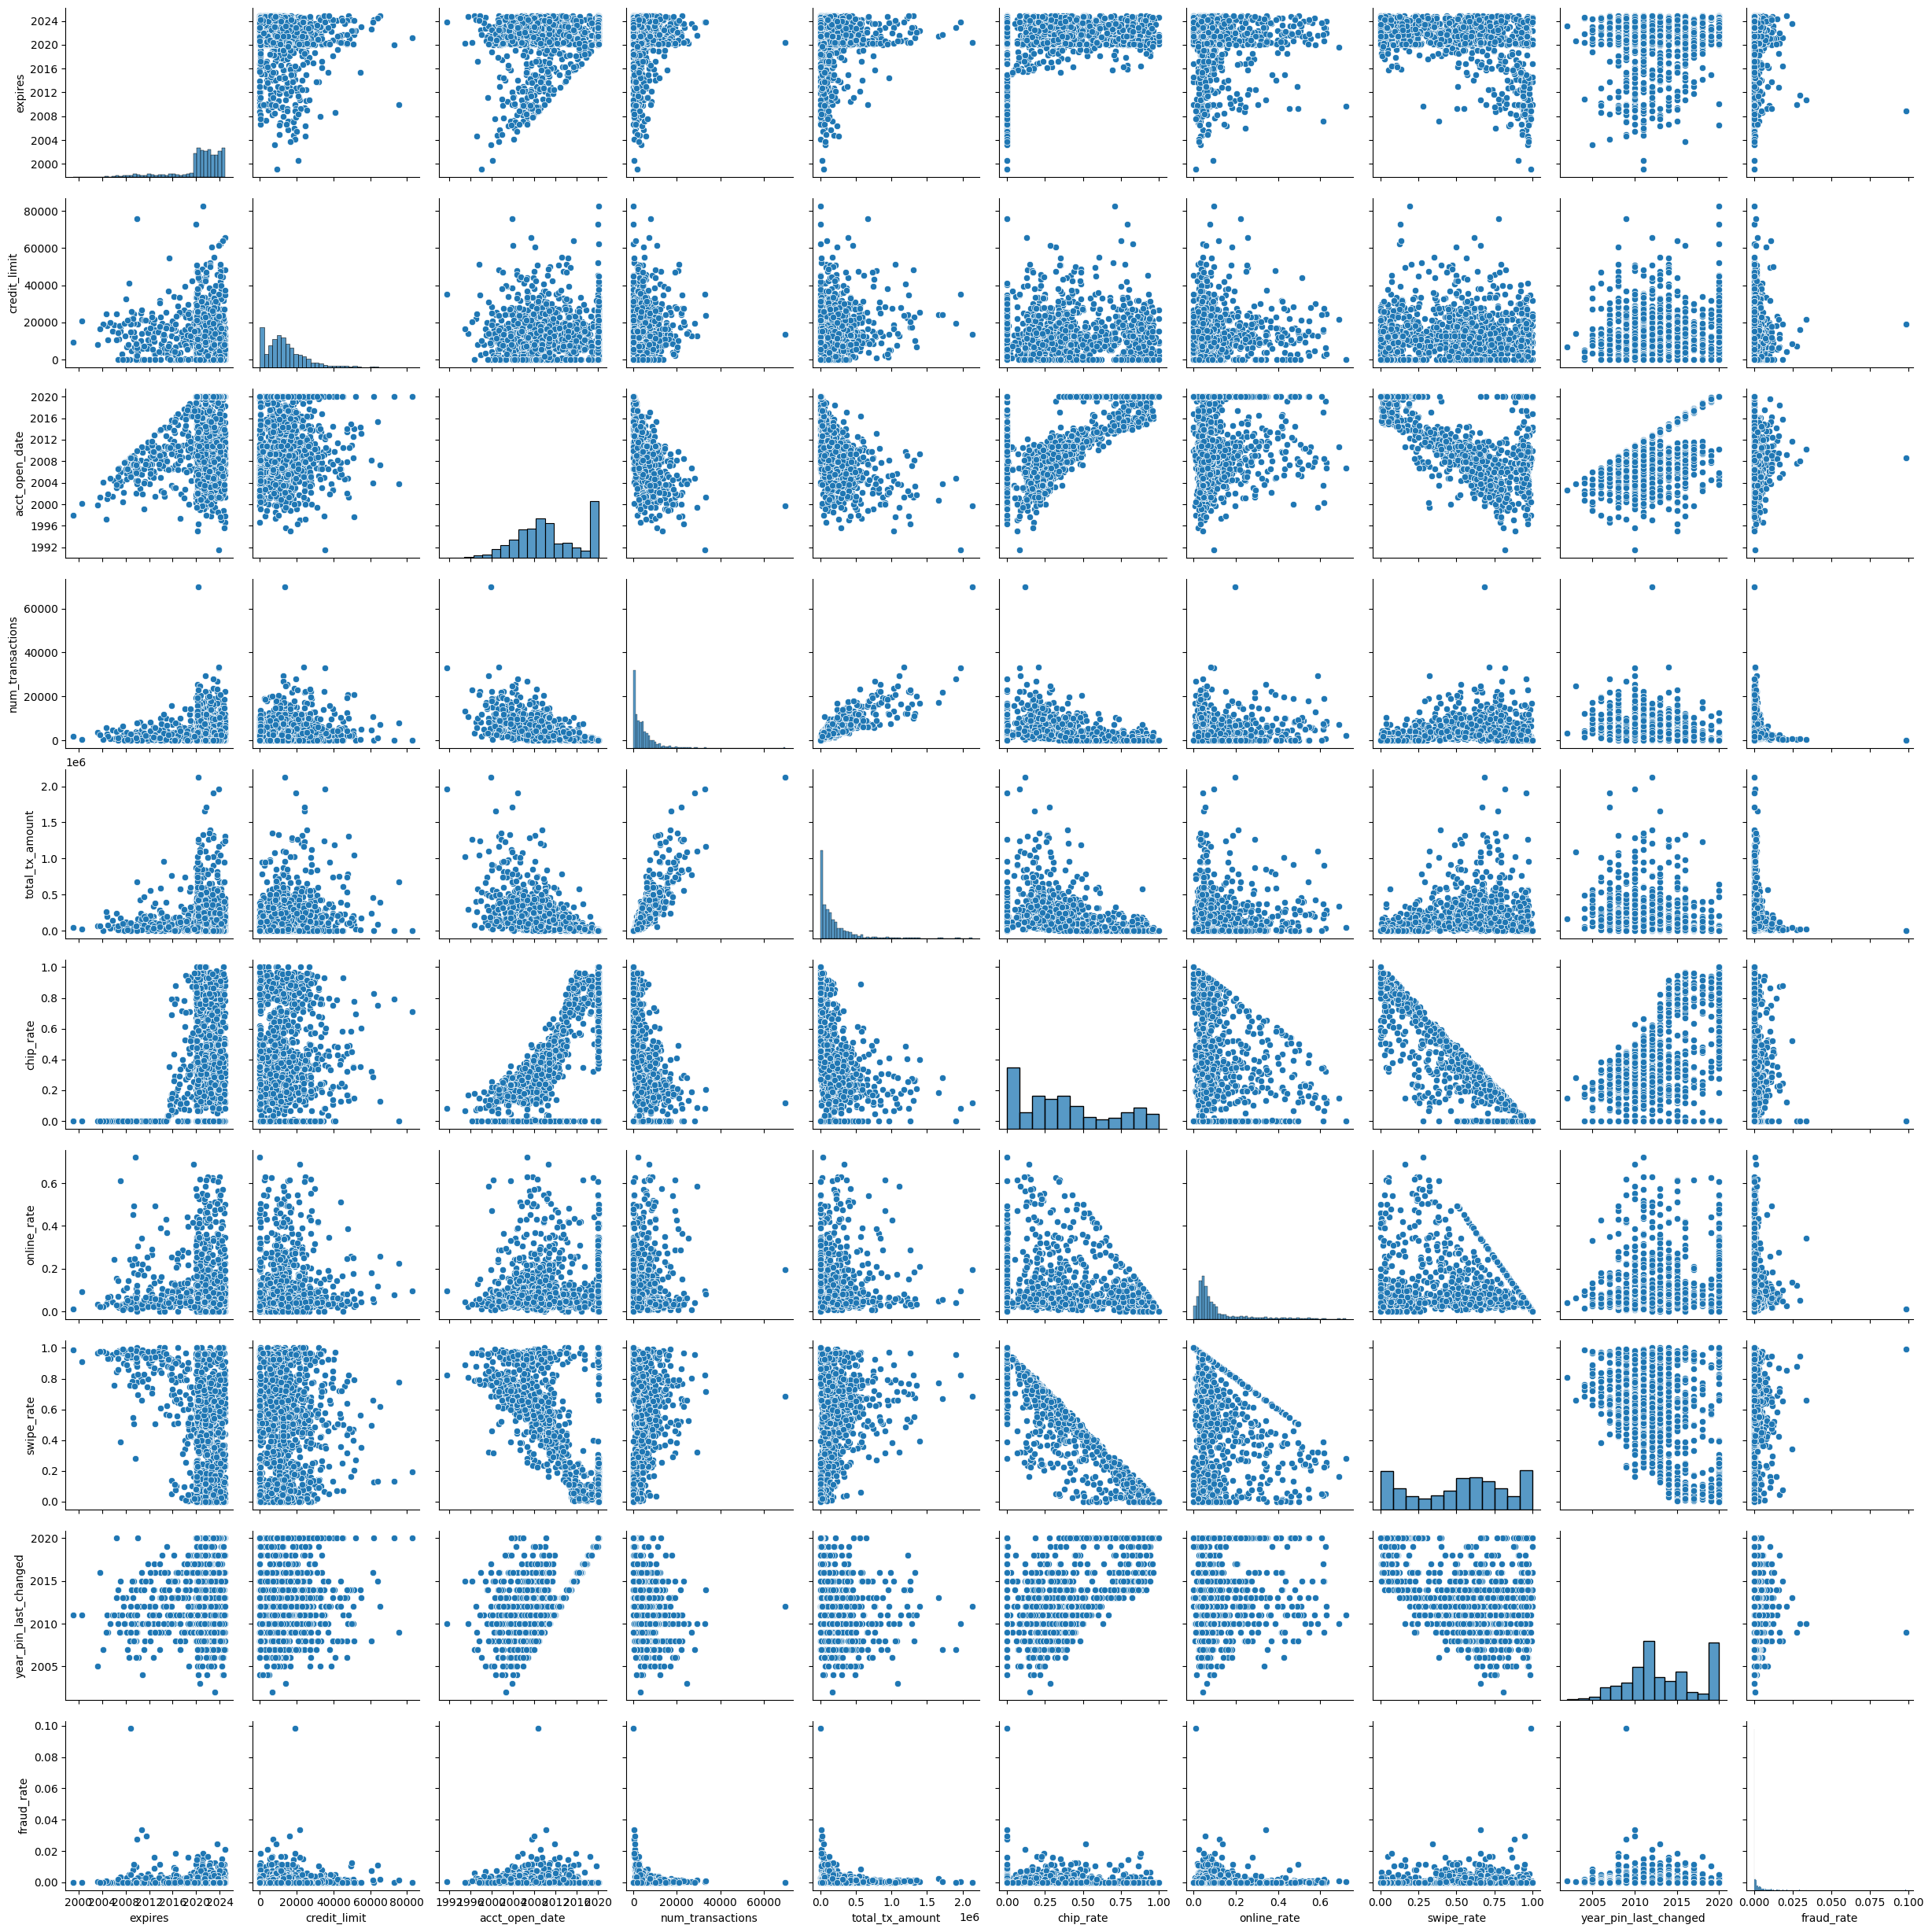

In [19]:
sns.pairplot(card_data, vars=card_cont_vars);

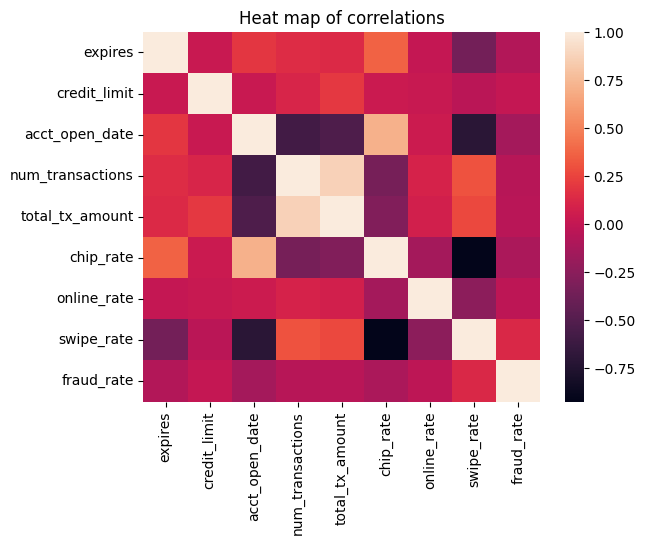

In [33]:
sns.heatmap(card_data[card_cont_vars].corr());
plt.title('Heat map of correlations');

# Variations by user and user characteristics

In [5]:
user_data = pd.read_csv(utils.prepend_dir('users_sample.csv'), index_col=0)
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 2 to 1987
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person                     400 non-null    object 
 1   current_age                400 non-null    int64  
 2   retirement_age             400 non-null    int64  
 3   birth_year                 400 non-null    int64  
 4   birth_month                400 non-null    int64  
 5   gender                     400 non-null    object 
 6   address                    400 non-null    object 
 7   apartment                  102 non-null    float64
 8   city                       400 non-null    object 
 9   state                      400 non-null    object 
 10  zipcode                    400 non-null    int64  
 11  latitude                   400 non-null    float64
 12  longitude                  400 non-null    float64
 13  per_capita_income_zipcode  400 non-null    float64
 14

As noted already, fraudulent transactions are rare in the data overall as a share of transactions, but they are not uncommon for users. Over $\frac{2}{3}$ of the users in the data have been the victims of at least one fraudulent transaction.

In [35]:
print(user_data.fraud_rate.describe())
print(f"{(user_data.fraud_rate>0).mean()*100:.0f}% of users have experienced at least 1 fraudulent transaction.")

count    400.000000
mean       0.001021
std        0.001288
min        0.000000
25%        0.000000
50%        0.000581
75%        0.001599
max        0.009955
Name: fraud_rate, dtype: float64
69% of users have experienced at least 1 fraudulent transaction.


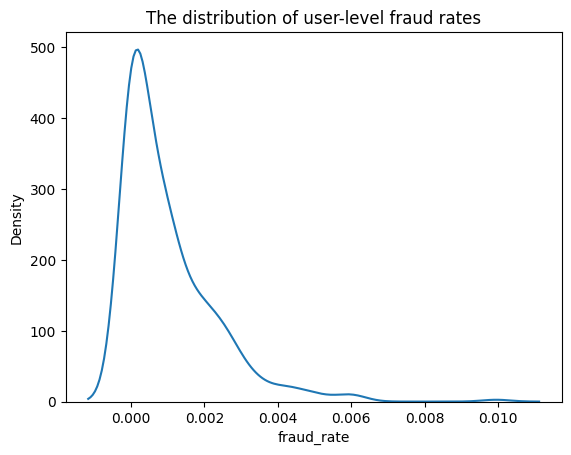

In [22]:
sns.kdeplot(user_data, x='fraud_rate');
plt.title('The distribution of user-level fraud rates');

In [36]:
user_cont_vars = ['birth_year', 'current_age', 'per_capita_income_zipcode', 'yearly_income_person', 'total_debt', 'fico_score', 'num_credit_cards', 'total_credit_limit', 'fraud_rate']

Because there are more continuous measures in the aggregated data, a grid of scatterplots is a useful visualization. The plots below do not bring out too many striking patterns. The extremely close association between average income and user income is probably an artifact of the simulation.

Looking in particular at the bottom row, for which fraud rate is the y-axis, it is hard to see clear correlations, in part because the fraud rate is truncated at 0. Look at the correlation coefficients, there is a positive association with age (negative with birth year), number of credit cards, and total credit limit (noting that the latter two are themselves strongly correlated).

Text(0.5, 1.0, 'Pairwise plots of variables in the user data')

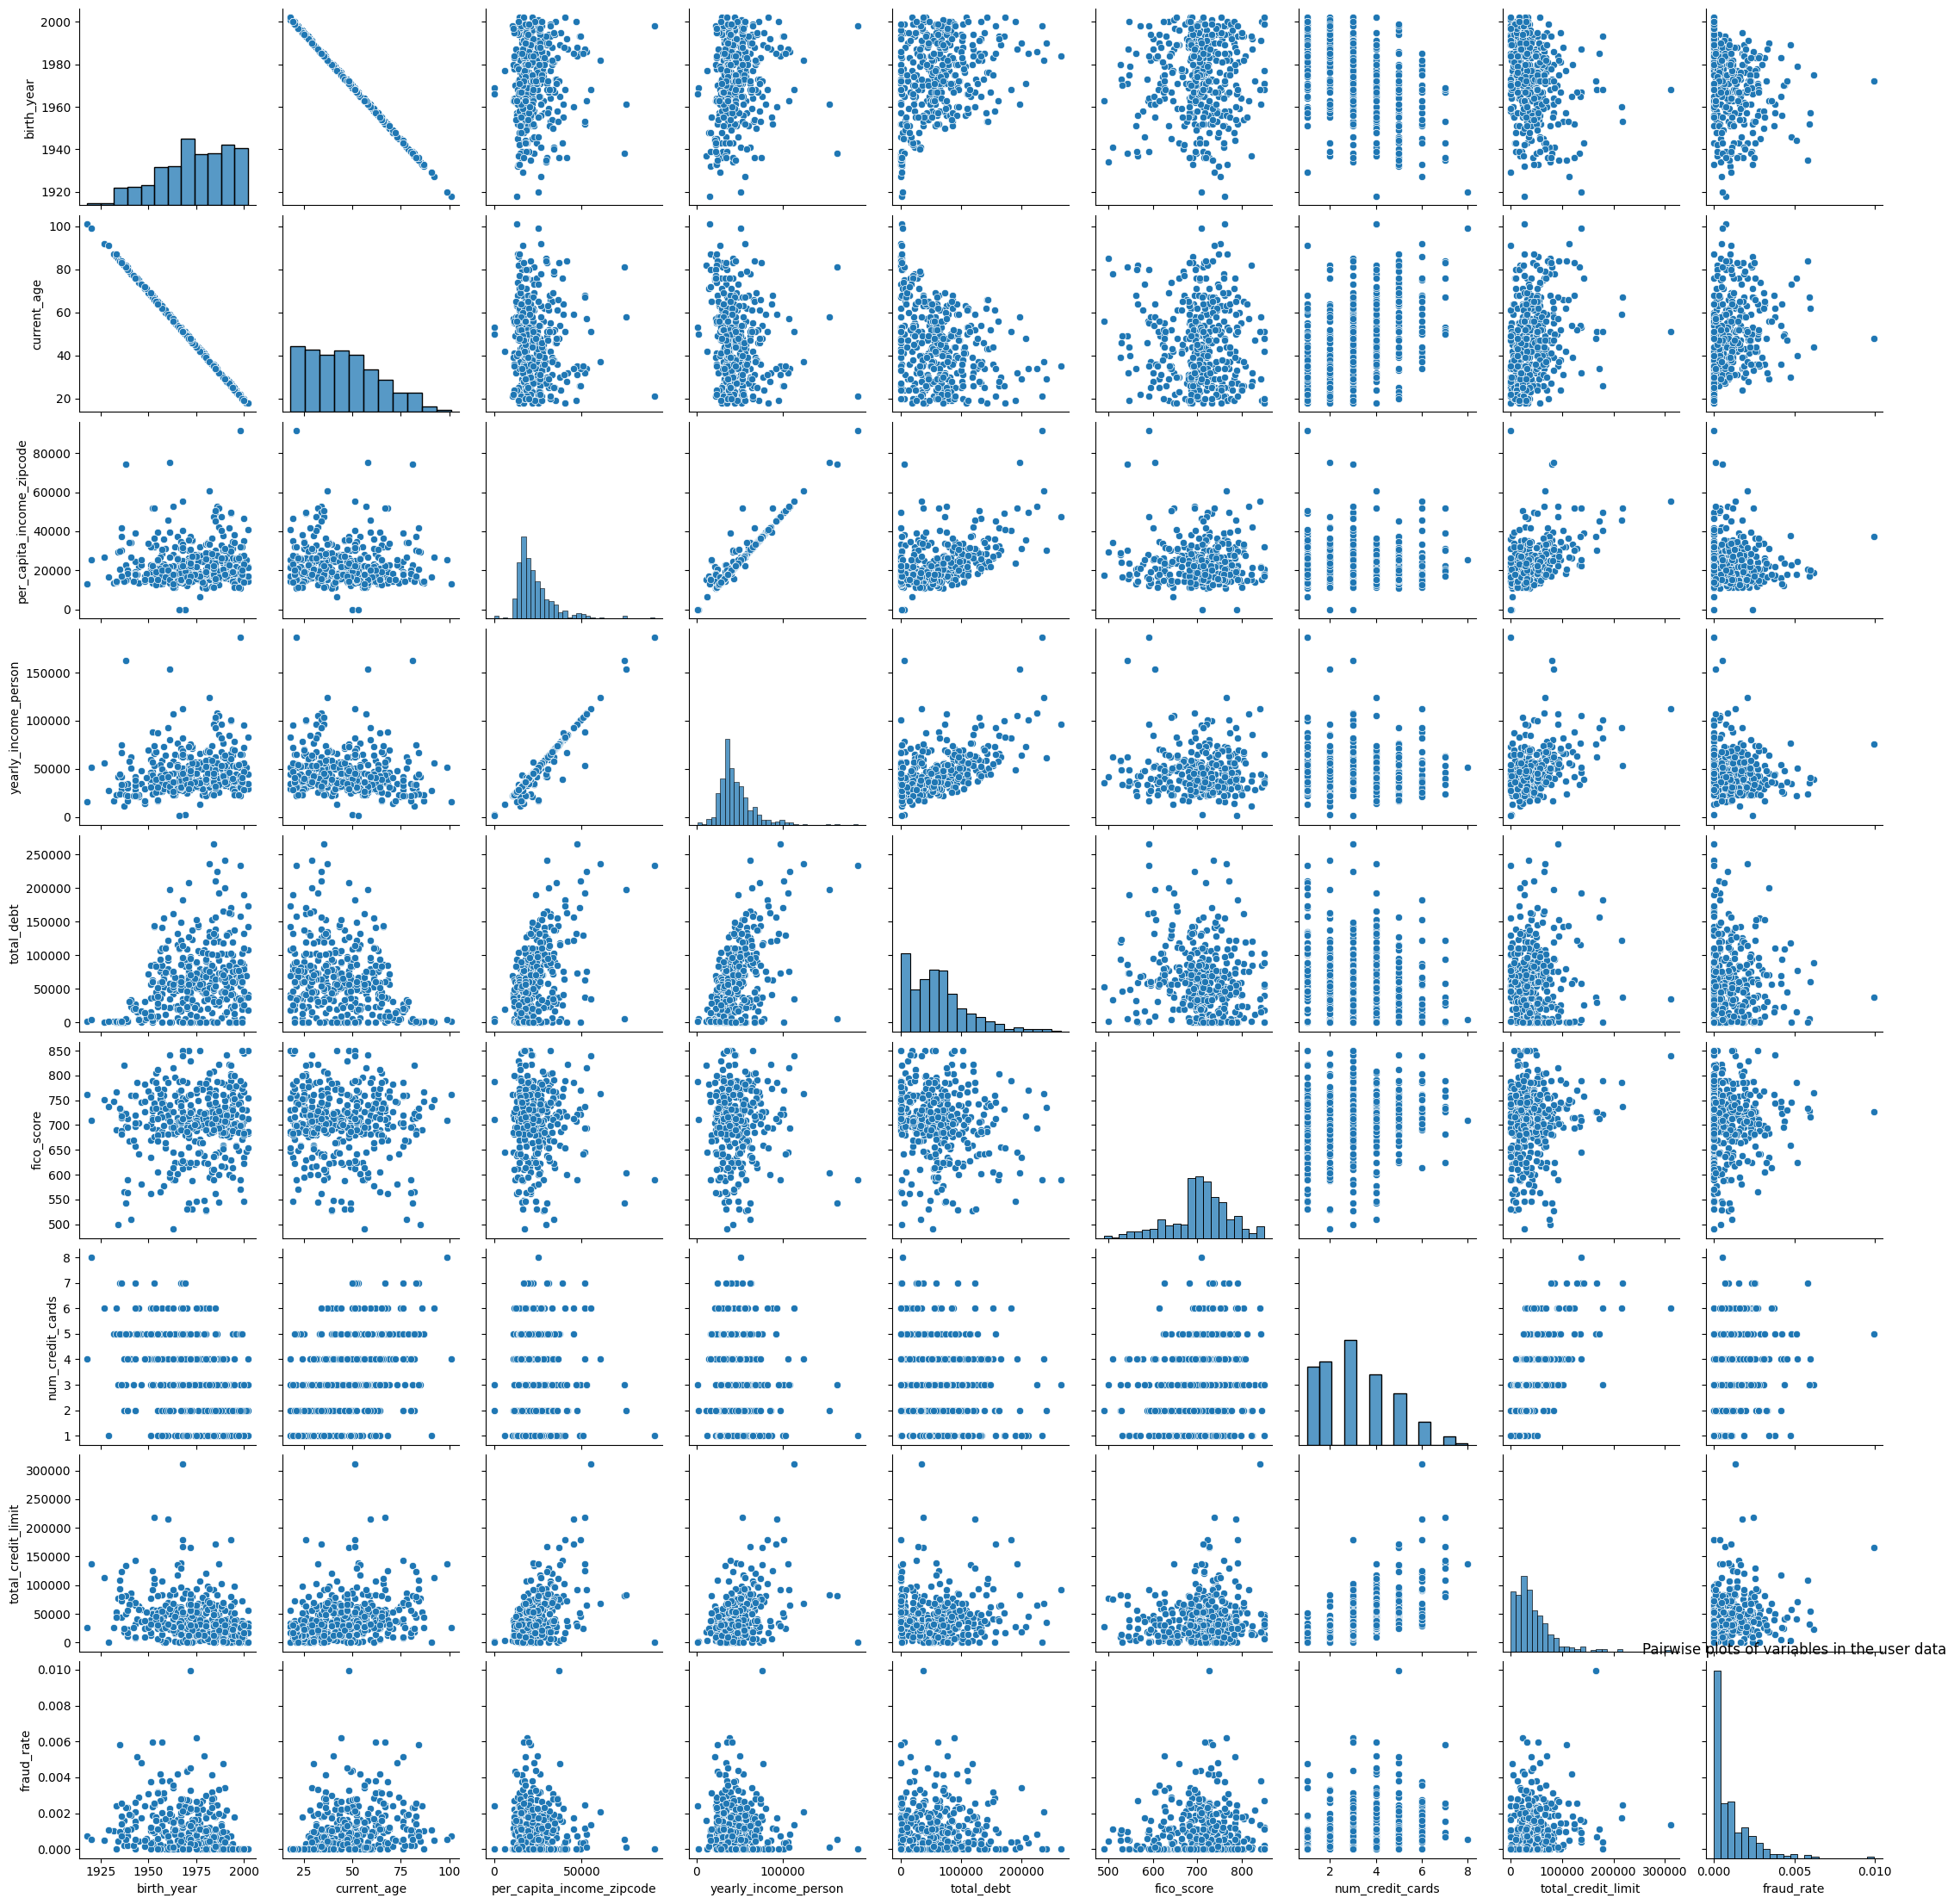

In [37]:
sns.pairplot(user_data, vars=user_cont_vars);
plt.title("Pairwise plots of variables in the user data")

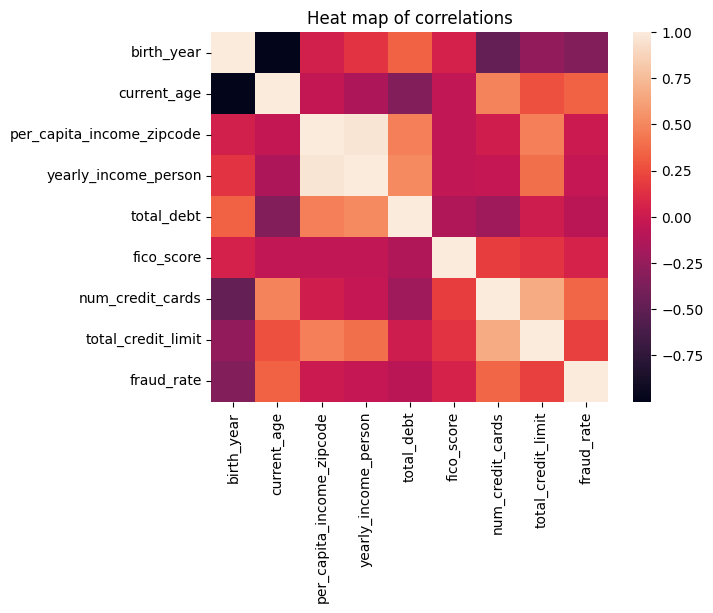

In [38]:
sns.heatmap(user_data[user_cont_vars].corr());
plt.title('Heat map of correlations');

## Space

To continue a point from above, one specific question worth asking is how the uneven spatial patterns of fraud interact with user's own locations. That is to say: is a transaction outside a user's home zip code, city, or state more likely to be fraudulent?

In [39]:
loc_df = tx_data[['user', 'zip', 'merchant_city', 'merchant_state', 'is_fraud']].merge(user_data[['city', 'state', 'zipcode']], right_index=True, left_on='user')
loc_df.head(3).T

,28882,28883,28884
user,2,2,2
zip,NaN,NaN,91792.0
merchant_city,ONLINE,ONLINE,West Covina
merchant_state,NaN,NaN,CA
is_fraud,False,False,False
city,West Covina,West Covina,West Covina
state,CA,CA,CA
zipcode,91792,91792,91792


In [40]:
loc_df['home_city'] = np.logical_and(loc_df.city == loc_df.merchant_city, loc_df.state == loc_df.merchant_state)
loc_df['home_zip'] = loc_df.zip == loc_df.zipcode
loc_df[['home_city', 'home_zip']].mean()

home_city    0.561518
home_zip     0.502568
dtype: float64

In [41]:
print(loc_df.groupby('home_city').is_fraud.agg(['count', 'mean']))
print(loc_df.groupby('home_zip').is_fraud.agg(['count', 'mean']))
print(loc_df[~loc_df.zip.isna()].groupby('home_zip').is_fraud.agg(['count', 'mean']))

             count      mean
home_city                   
False      2286599  0.002584
True       2928208  0.000048
            count      mean
home_zip                   
False     2594010  0.002316
True      2620797  0.000016
            count      mean
home_zip                   
False     1953049  0.000469
True      2620797  0.000016


On average, about half of the transactions are in the users' home cities or home zipcodes (the latter being a slightly more strict measure, since large metropolitan areas have more than one zip code). This is closer to 2/3 among in-person transactions. Fraudulent credit card transactions are **much** more common outside the user's home zip. As seen above, online transactions have particularly high rates, but away-from-home in-person transactions also have significantly higher rates as well.

An in-person transaction in a user's home zip code is vanishingly unlikely (under 2 in 100,000 transactions). Away-from-home fraudulent transactions are about 5 in 10,000. This is rare, but considering that the median card in the data set has over 2,000 transactions, it is a real possibility.

The flipside of this, though, is that the vast majority of online and away-from-home transactions are legitimate. A 0.2%, let alone 0.05%, risk is not actionable intelligence on its own.

## Time

#### Age

One final issue relates to issues of time. There was a weak correlation between age and fraud rate in the user data. This is a static measure of age at the time of the data set's creation (2019). It would be good to have instead a measure of the user's age at the time of the transaction.

The analysis below shows that there seems to be a inverse U-shaped pattern for age.

In [10]:
# no birth days given, so using 1 for all
user_data['birthdate'] = pd.to_datetime({'year': user_data.birth_year, 'month': user_data.birth_month, 'day':1})
user_data.head(2).T

,2,15
person,Saanvi Lee,Riya Cruz
current_age,81,41
retirement_age,67,68
birth_year,1938,1978
birth_month,11,4
gender,Female,Female
address,766 Third Drive,40 Washington Drive
apartment,NaN,NaN
city,West Covina,Boise City
state,CA,OK


In [11]:
age_df = tx_data[['user', 'timestamp', 'is_fraud']].merge(user_data[['birthdate', 'retirement_age']], left_on='user', right_index=True)
age_df['age'] = (age_df.timestamp - age_df.birthdate).dt.days/365
age_df.head()

,user,timestamp,is_fraud,birthdate,retirement_age,age
28882,2,2009-09-26 01:56:00,False,1938-11-01,67,70.950685
28883,2,2009-10-01 04:13:00,False,1938-11-01,67,70.964384
28884,2,2009-10-01 10:49:00,False,1938-11-01,67,70.964384
28885,2,2009-10-01 14:30:00,False,1938-11-01,67,70.964384
28886,2,2009-10-02 04:25:00,False,1938-11-01,67,70.967123


The victims of credit card fraud are slightly older, on average.

In [44]:
age_df.groupby('is_fraud').age.agg(['mean', 'median', 'std']).T

is_fraud,False,True
mean,46.770250,48.297830
median,44.663014,46.046575
std,15.950342,15.755311


In [45]:
age_diff = age_df[age_df.is_fraud].age.mean() - age_df[~age_df.is_fraud].age.mean()
age_diff_bootstrap = bootstrap_bool(
    age_df.is_fraud.mean(), 
    age_df.is_fraud.count(), 
    age_df.age, 
    lambda is_fraud, age: np.abs(age[is_fraud].mean()-age[~is_fraud].mean())
)
print(f'The probability of observing a mean difference in ages of at least {age_diff:.2f} is {(age_diff_bootstrap >= age_diff).mean()}')

The probability of observing a mean difference in ages of at least 1.53 is 0.0


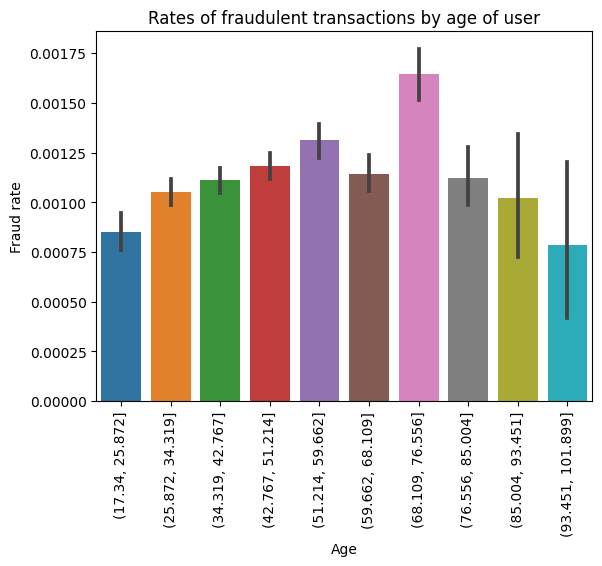

In [46]:
age_df['age_bins'] = pd.cut(age_df.age, 10)
ax = sns.barplot(age_df, x='age_bins', y='is_fraud');
ax.tick_params(axis='x', labelrotation=90);
ax.set_title('Rates of fraudulent transactions by age of user');
ax.set_xlabel('Age');
ax.set_ylabel('Fraud rate');

#### Retirement

The retirement age in the users data makes it possible to indicate whether the user was retired at the time of any transaction.

In [12]:
age_df['retired'] = age_df.age >= age_df.retirement_age
age_df.retired.describe()

count     5214807
unique          2
top         False
freq      4482055
Name: retired, dtype: object

In [19]:
age_df.pivot_table('is_fraud', 'retired')

,is_fraud
retired,
False,0.001136
True,0.001306


There is a small difference. Perhaps combined with other variables it will be useful.

#### Card vintage and lifetime

There seems to be mild patterns in the bivariate data with fraud rate and the expiration date and account opening dates for cards. We can explore whether a transaction is more likely to be fraudulent depending on how long it has been since the account was formed or how long remains until the card expires. Perhaps risk grows with time.

In [6]:
card_vintage = tx_data[['user', 'card', 'timestamp', 'is_fraud']].merge(card_data[['user', 'card_index', 'expires', 'year_pin_last_changed', 'acct_open_date']], left_on=['user', 'card'], right_on=['user', 'card_index'])
card_vintage.head()

,user,card,timestamp,is_fraud,card_index,expires,year_pin_last_changed,acct_open_date
0,2,0,2009-09-26 01:56:00,False,0,2022-03-01,2009,2009-10-01
1,2,0,2009-10-01 04:13:00,False,0,2022-03-01,2009,2009-10-01
2,2,0,2009-10-01 10:49:00,False,0,2022-03-01,2009,2009-10-01
3,2,0,2009-10-01 14:30:00,False,0,2022-03-01,2009,2009-10-01
4,2,0,2009-10-02 04:25:00,False,0,2022-03-01,2009,2009-10-01


In [15]:
card_vintage['until_expired'] = card_vintage.expires - card_vintage.timestamp
card_vintage['since_opened'] = card_vintage.timestamp - card_vintage.acct_open_date
card_vintage['years_since_pin'] = card_vintage.timestamp.dt.year - card_vintage.year_pin_last_changed
card_vintage['expired'] = card_vintage.expires < card_vintage.timestamp
card_vintage.head().T

,0,1,2,3,4
user,2,2,2,2,2
card,0,0,0,0,0
timestamp,2009-09-26 01:56:00,2009-10-01 04:13:00,2009-10-01 10:49:00,2009-10-01 14:30:00,2009-10-02 04:25:00
is_fraud,False,False,False,False,False
card_index,0,0,0,0,0
expires,2022-03-01 00:00:00,2022-03-01 00:00:00,2022-03-01 00:00:00,2022-03-01 00:00:00,2022-03-01 00:00:00
year_pin_last_changed,2009,2009,2009,2009,2009
acct_open_date,2009-10-01 00:00:00,2009-10-01 00:00:00,2009-10-01 00:00:00,2009-10-01 00:00:00,2009-10-01 00:00:00
until_expired,4538 days 22:04:00,4533 days 19:47:00,4533 days 13:11:00,4533 days 09:30:00,4532 days 19:35:00
since_opened,-5 days +01:56:00,0 days 04:13:00,0 days 10:49:00,0 days 14:30:00,1 days 04:25:00


There are apparently a small number of transactions that are listed as occuring **before** the account was listed as opened, similarly for after card expiration. The former seems likely to be a data entry (or more accurately, simulation) error, while there are enough of the latter to think that these are transactions where the company allowed a charge on an expired card (perhaps while a new card had not been activated?).

The `pin last changed` variable cannot be used in the same way as account opened or card expired, because there is not information on pin changes prior to the last. Perhaps how old the pin is can be used as a measure of the riskiness of the card, though arguably using this is "cheating" insofar as in a hypothetical deployed model, what would be known is not this backwards-looking value but instead how old the pin is in a card being used in a given transaction. To use it here, the assumption would have to be that the pin "age" observed at the end point of the training data is somehow representative of how long those users go without updating pin. Perhaps it makes sense then to average cards across a user? Except another problem is that in some cases, older year of pin chang just reflects an old card.

In [13]:
print(card_vintage.since_opened.describe())
print(f'{np.sum(card_vintage.since_opened < pd.Timedelta(0))} transactions before account opened\n')
print(card_vintage.until_expired.describe())
print(f'{np.sum(card_vintage.until_expired < pd.Timedelta(0))} transactions after card expired\n')
print(card_vintage.years_since_pin.describe())

count                         5214807
mean     2182 days 04:33:47.357514848
std      1648 days 14:21:36.639747008
min               -634 days +00:24:00
25%                 823 days 15:59:00
50%                1860 days 20:00:00
75%                3229 days 09:47:30
max               10469 days 02:25:00
Name: since_opened, dtype: object
310 transactions before account opened

count                         5214807
mean     3273 days 18:08:47.662910752
std      1953 days 01:30:08.982966400
min                -42 days +07:05:00
25%                1738 days 16:36:30
50%                3018 days 05:46:00
75%                4602 days 05:21:00
max               11810 days 11:24:00
Name: until_expired, dtype: object
12838 transactions after card expired

count    5.214807e+06
mean     7.866441e-01
std      5.595123e+00
min     -2.000000e+01
25%     -3.000000e+00
50%      1.000000e+00
75%      5.000000e+00
max      1.800000e+01
Name: years_since_pin, dtype: float64


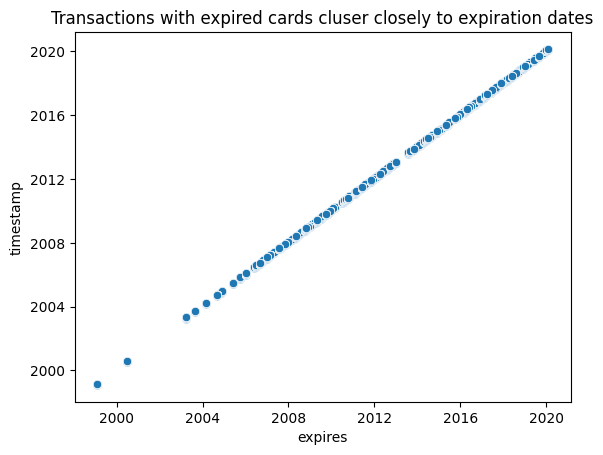

In [17]:
sns.scatterplot(card_vintage[card_vintage.expired], x='expires', y='timestamp');
plt.title('Transactions with expired cards cluster closely to expiration dates');

# Conclusions

The analysis in this notebook reveals a few key points that will inform modeling.
1. Although some records go back to the 1990s, the bulk of the data is from the 2000s.
1. Transactions show distinctive patterns in terms of amount: for payments, smaller transactions are the more common, while refunds only occur regularly for somewhat larger amounts. Fraudulent transactions are almost all payments, and they show a different pattern in terms amount: although smaller amounts are still more common, they are relatively less so. Thus, the average fraudulent transaction is larger.
1. The location of the transaction is highly significant. Fraudulent transactions are an order of magnitude more common outside of a user's home area if in person, and a further order of magnitude more common online.
1. Older users are somewhat more at risk.
1. Admist all of these variations, the fraud rate is never very high as a share of transactions. It is probably impossible to arrive at a high-confidence prediction that any given transaction is **most likely** fraudulent. A more realistic problem, instead, is to establish a risk threshold above which some further action (e.g. confirmation with user) is to be taken. Obviously, checking with the user after every transaction, or every handful of transactions, is not workable. But a small nuisance periodically (say, once a month), if it can catch a large number of fraudulent transactions, could be valuable.